In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[torch]
except Exception:
    pass

In [2]:
# You will need matplotlib for visualing our dataset and numpy to be able to handle the data.
import matplotlib.pyplot as plt
import numpy as np

# You are importing torch in order to create image embeddings.
# You are only using torchvision to load in the dataset.
# If you already have the data stored on your computer in a numpy friendly manner,
# then feel free to load it directly into numpy arrays.
import torch
import torch.nn as nn
import torchvision.transforms.v2 as v2
from torchvision import datasets, models

# Load the classes from DataEval that are helpful for EDA
from dataeval.detectors.linters import Clusterer
from dataeval.metrics.bias import coverage

# Set the random value
rng = np.random.default_rng(213)

In [3]:
# Download the data and then load it as a torch Tensor.
to_tensor = v2.ToImage()
ds = datasets.VOCDetection("./data", year="2011", image_set="train", download=True, transform=to_tensor)

Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


In [4]:
# Verify the size of the loaded dataset
len(ds)

5717

In [5]:
# Define the embedding network
class EmbeddingNet(nn.Module):
    """
    Simple CNN that repurposes a pretrained ResNet18 model by overwriting the last linear layer.
    Results in a last layer dimension of 128.
    """

    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, 128)

    def forward(self, x):
        x = self.model(x)
        return x


# Initialize the network
embedding_net = EmbeddingNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_net.to(device)


# Extract embeddings
def extract_embeddings(dataset, model):
    """Helper function to stack image embeddings from a model"""
    model.eval()

    embeddings = torch.empty(size=(0, 128)).to(device)
    with torch.no_grad():
        images = []
        for i, (img, _) in enumerate(dataset):
            images.append(img)
            if (i + 1) % 64 == 0:
                inputs = torch.stack(images, dim=0).to(device)
                outputs = model(inputs)
                embeddings = torch.vstack((embeddings, outputs))
                images = []
        inputs = torch.stack(images, dim=0).to(device)
        outputs = model(inputs)
        embeddings = torch.vstack((embeddings, outputs))
    return embeddings.detach().cpu().numpy()

In [6]:
# Define pretrained model transformations
preprocess = models.ResNet18_Weights.DEFAULT.transforms()

# Load the dataset
dataset = datasets.VOCDetection("./data", year="2011", image_set="train", download=False, transform=preprocess)

# Create image embeddings
embeddings = extract_embeddings(dataset, embedding_net)

In [7]:
# Normalize image embeddings
norm_embeddings = (embeddings - embeddings.min()) / (embeddings.max() - embeddings.min())

In [8]:
# This cell takes about 5-10 minutes to run depending on your hardware

# Initialize the Clusterer class (with the embedded images)
cluster = Clusterer(norm_embeddings)

# Find the outlier images
results = cluster.evaluate()

# View the number of outliers
print(f"Number of outliers: {len(results.outliers)}")
print(f"Number of potential outliers: {len(results.potential_outliers)}")

Number of outliers: 437
Number of potential outliers: 3509


/workspaces/dataeval/.tox/docs/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/workspaces/dataeval/.tox/docs/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


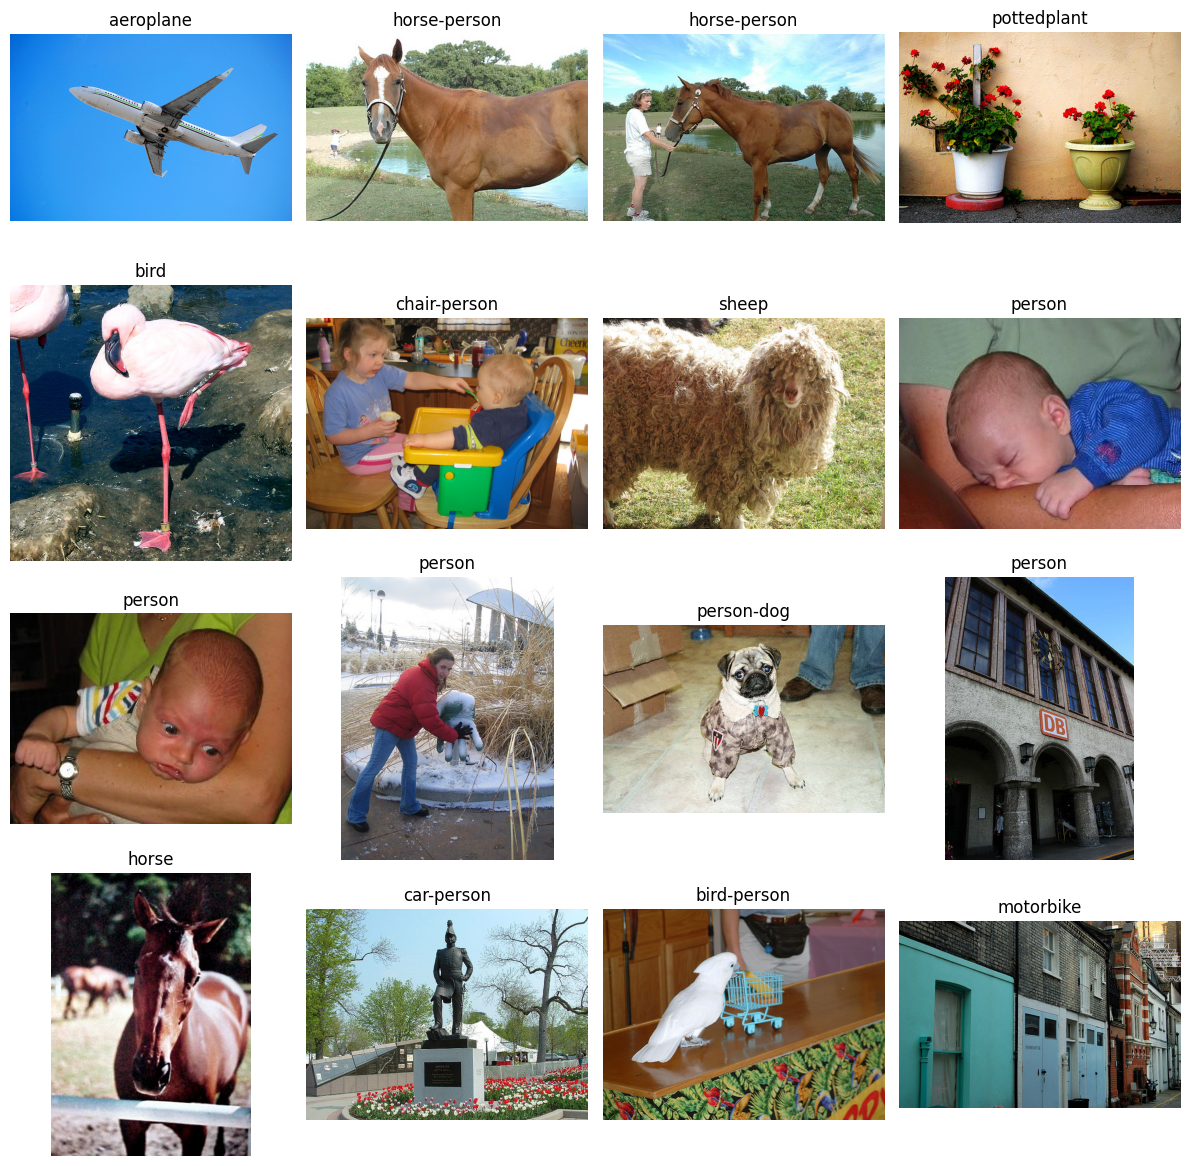

In [9]:
# Plot random images from each category
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    # Selected image
    selected_index = results.outliers[i]

    # Grabbing the object names
    names = []
    objects = ds[selected_index][1]["annotation"]["object"]
    for each in objects:
        names.append(each["name"])

    # Plot the corresponding image - need to permute to get channels last for matplotlib
    ax.imshow(np.moveaxis(ds[selected_index][0].numpy(), 0, -1))
    ax.set_title("-".join(set(names)))
    ax.axis("off")

plt.tight_layout()
plt.show()

In [10]:
# Measure the coverage of the embeddings
embedding_coverage = coverage(norm_embeddings)

print(f"Number of uncovered data points: {len(embedding_coverage.indices)}\n{embedding_coverage}")

Number of uncovered data points: 57
CoverageOutput(indices=array([4075, 3005, 3104, 4296, 2495, 1220, 4245, 1365, 1069, 2813,  331,
        292, 3728, 3486,  491, 2412, 4890, 4373, 2557, 1657,  991, 2313,
       3607, 1403, 3602, 3041, 3028, 2829, 1646, 3838, 2065, 3100, 2545,
       2687, 1705, 5659, 3046, 3733, 2550, 3739, 5513, 1723, 4295, 2898,
        909, 1989, 2896, 3892, 5077, 2527, 4027, 1914, 3102, 4699, 2373,
       1709,  417]), radii=array([0.76766441, 0.84453738, 0.84304599, ..., 0.68657249, 0.64805093,
       0.71288216]), critical_value=0.9378205539855354)


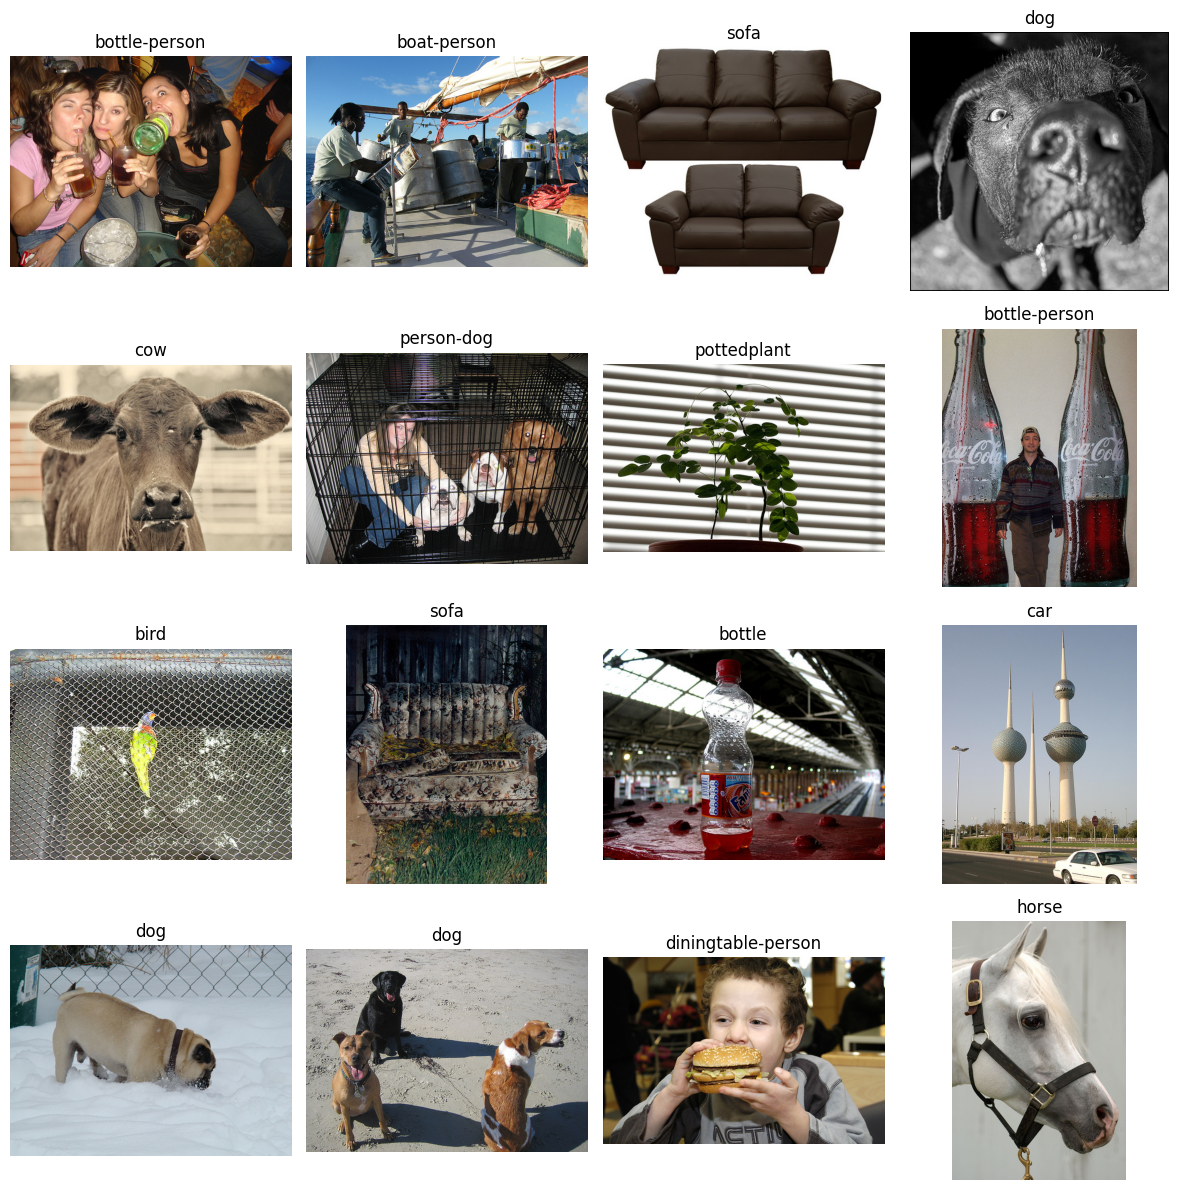

In [11]:
# Plot random images from each category
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    # Selected image
    selected_index = embedding_coverage.indices[i]

    # Grabbing the object names
    names = []
    objects = ds[selected_index][1]["annotation"]["object"]
    for each in objects:
        names.append(each["name"])

    # Plot the corresponding image - need to permute to get channels last for matplotlib
    ax.imshow(np.moveaxis(ds[selected_index][0].numpy(), 0, -1))
    ax.set_title("-".join(set(names)))
    ax.axis("off")

plt.tight_layout()
plt.show()

In [12]:
uncovered_outliers = [x for x in embedding_coverage.indices if x in results.outliers]
print(
    f"Number of images identified by both functions: {len(uncovered_outliers)} \
        out of {len(embedding_coverage.indices)} possible"
)
print(uncovered_outliers)

Number of images identified by both functions: 54         out of 57 possible
[4075, 3005, 3104, 4296, 2495, 1220, 4245, 1365, 1069, 2813, 331, 292, 3728, 3486, 491, 2412, 4890, 4373, 2557, 1657, 991, 2313, 3607, 1403, 3602, 3041, 3028, 2829, 1646, 3838, 2065, 3100, 2545, 2687, 1705, 5659, 3046, 3733, 2550, 3739, 5513, 1723, 4295, 2898, 909, 1989, 3892, 5077, 2527, 4027, 3102, 2373, 1709, 417]


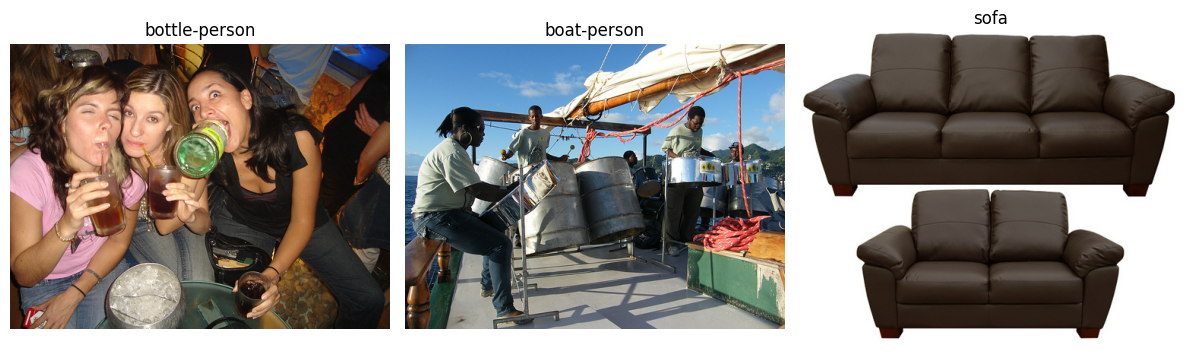

In [13]:
uncovered_only = [x for x in embedding_coverage.indices if x not in uncovered_outliers]

# Plot random images from each category
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axs.flat):
    # Selected image
    selected_index = uncovered_outliers[i]

    # Grabbing the object names
    names = []
    objects = ds[selected_index][1]["annotation"]["object"]
    for each in objects:
        names.append(each["name"])

    # Plot the corresponding image - need to permute to get channels last for matplotlib
    ax.imshow(np.moveaxis(ds[selected_index][0].numpy(), 0, -1))
    ax.set_title("-".join(set(names)))
    ax.axis("off")

plt.tight_layout()
plt.show()